# Network-Driven Drug Discovery Workflow Demonstration

This notebook demonstrates the AI-driven drug discovery workflow using a single disease example. You will:
- Select a disease and its gene/protein targets
- Run the workflow to analyze and rank candidate compounds
- Visualize the disease network and candidate rankings
- Export results for further use

**Example Disease:** Parkinson disease

In [1]:
# Section 1: Select a Disease for Demonstration
# You can change these variables to try other diseases and gene targets

disease = "Parkinson disease"
gene_targets = ["SNCA", "LRRK2", "PARK2", "PINK1"]
print(f"Selected disease: {disease}")
print(f"Gene targets: {gene_targets}")

Selected disease: Parkinson disease
Gene targets: ['SNCA', 'LRRK2', 'PARK2', 'PINK1']


## Section 2: Load and Preprocess Data

This step loads the relevant data for the selected disease and gene targets. The workflow will use these inputs to query compound databases and build the disease network.

In [2]:
# Load workflow modules and preprocess inputs
from agents.design_agent import DesignAgent
from agents.validation_agent import ValidationAgent
from agents.approval_agent import ApprovalAgent
from tools.network import build_disease_network, run_gnn_analysis
from tools.kegg_pathway import get_pathways_from_kegg
from tools.chembl_target import get_chembl_compounds_for_target
import matplotlib.pyplot as plt
import networkx as nx
import pandas as pd

# Preprocess: Get pathways and build network
pathways = get_pathways_from_kegg(disease)
network = build_disease_network(pathways, gene_targets)
network_insights = run_gnn_analysis(network)
compound_results = {}
for target in gene_targets:
    compounds = get_chembl_compounds_for_target(target, max_results=1)
    compound_results[target] = compounds

Skipping import of cpp extensions due to incompatible torch version 2.9.1 for torchao version 0.13.0
W1202 19:54:49.974000 17343 torch/distributed/elastic/multiprocessing/redirects.py:29] NOTE: Redirects are currently not supported in Windows or MacOs.
W1202 19:54:49.974000 17343 torch/distributed/elastic/multiprocessing/redirects.py:29] NOTE: Redirects are currently not supported in Windows or MacOs.


## Section 3: Run Workflow Steps for Selected Disease

This cell runs the main workflow steps: agent analysis, candidate ranking, and result aggregation.

In [3]:
# Run agents and rank candidates

design_agent = DesignAgent()
validation_agent = ValidationAgent()
approval_agent = ApprovalAgent()
design_results = {}
for target, compounds in compound_results.items():
    for compound in compounds:
        chembl_id = compound.get("chembl_id")
        if not chembl_id:
            continue
        design = design_agent.run(chembl_id)
        validation = validation_agent.run(chembl_id)
        approval = approval_agent.run(chembl_id)
        design_results[(target, chembl_id)] = {
            "design": design,
            "validation": validation,
            "approval": approval,
            "compound_info": compound
        }

def rank_candidates(design_results, network_insights):
    return sorted(design_results.items(), key=lambda x: network_insights.get(x[0][0], 0), reverse=True)

ranked_candidates = rank_candidates(design_results, network_insights)

Some weights of the model checkpoint at microsoft/BiomedNLP-PubMedBERT-base-uncased-abstract-fulltext were not used when initializing BertForMaskedLM: ['bert.pooler.dense.bias', 'bert.pooler.dense.weight', 'cls.seq_relationship.bias', 'cls.seq_relationship.weight']
- This IS expected if you are initializing BertForMaskedLM from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForMaskedLM from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Device set to use cpu
Device set to use cpu


## Section 4: Visualize Results

This cell generates plots and tables to visualize the disease network and ranked candidate compounds.

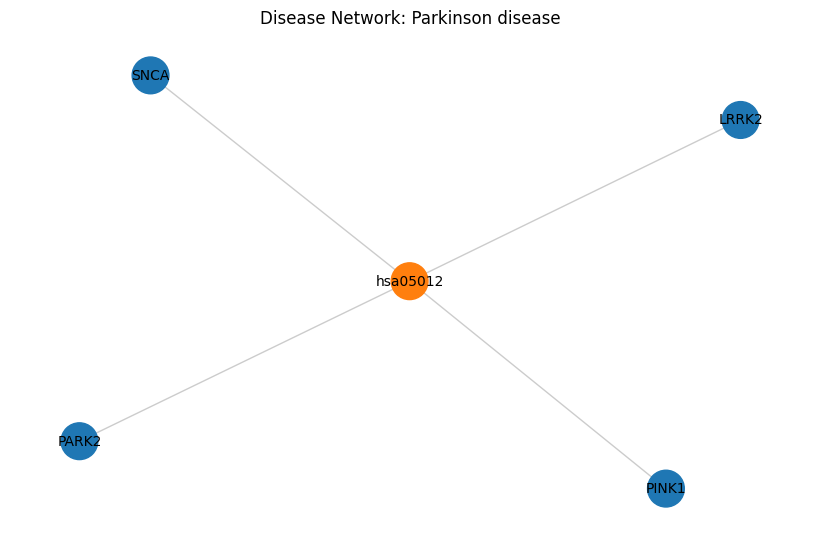

,Target,Compound,Score,MW,Formula,Summary
0,SNCA,CHEMBL404191,0.655422,523.5,C22H26IN3S2,PubMedBERT summary (top predictions):
1,PINK1,CHEMBL4209540,0.584299,318.4,C18H14N4S,PubMedBERT summary (top predictions):
2,LRRK2,CHEMBL509032,0.441399,614.2,C30H40ClN7O3S,PubMedBERT summary (top predictions):


In [4]:
# Visualize disease network
plt.figure(figsize=(8, 5))
pos = nx.spring_layout(network)
node_colors = ["#1f77b4" if network.nodes[n]["type"] == "gene" else "#ff7f0e" for n in network.nodes]
nx.draw(network, pos, with_labels=True, node_color=node_colors, edge_color="#cccccc", node_size=700, font_size=10)
plt.title(f"Disease Network: {disease}")
plt.show()

# Visualize ranked candidates as a table
rows = []
for (target, compound), result in ranked_candidates:
    score = network_insights.get(target, None)
    compound_info = result.get('design', {}).get('compound_info', {})
    summary = result.get('design', {}).get('llm_summary', '')
    rows.append({
        'Target': target,
        'Compound': compound,
        'Score': score,
        'MW': compound_info.get('properties', {}).get('molecular_weight', ''),
        'Formula': compound_info.get('properties', {}).get('formula', ''),
        'Summary': summary.split('\n')[0] if summary else ''
    })
df = pd.DataFrame(rows)
display(df)

## Section 5: Export Workflow Output

This cell provides code to export the ranked candidate table to a CSV file for further use or sharing.

In [5]:
# Export ranked candidates to CSV
output_path = "ranked_candidates_demo.csv"
df.to_csv(output_path, index=False)
print(f"Exported ranked candidates to {output_path}")

Exported ranked candidates to ranked_candidates_demo.csv


In [ ]:
# Plot histogram of ranked candidate scores
import matplotlib.pyplot as plt

scores = [row['Score'] for row in rows]
labels = [f"{row['Target']}-{row['Compound']}" for row in rows]
plt.figure(figsize=(8, 4))
plt.bar(labels, scores, color="#1f77b4")
plt.xticks(rotation=45, ha="right")
plt.ylabel("Network Vulnerability Score")
plt.title("Ranked Candidate Compounds by Target")
plt.tight_layout()
plt.show()